In [8]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from scripts.contrastive_learning_2d import ConstrativeLearningModel, SupConLoss

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = check_cuda()

CUDA is not available.
Device: cpu


# Data loaders

In [2]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, 
                      load_2d=True, load_3d=False, load_mass=False,
                      choose_two_2d = True,
                      DEBUG_LIMIT_FILES = None)

Preparing 2D data: 100%|██████████| 16544/16544 [00:38<00:00, 424.71it/s]


In [9]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


# Training loop

In [13]:
lr = 5e-2
n_epochs=5

#temperature = 0.07
temperature = 1.0
criterion = SupConLoss(temperature=temperature, device=device)

model = ConstrativeLearningModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':15, 'gamma':0.5},
                    criterion=criterion,
                    history=None,
                    transform=img2d_transform,
)

#model.load('SupConNetwork.pth')

#model.trial_forward_pass(train_loader, device);

In [14]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=None,
    num_epochs=n_epochs, 
    device=device)

Epochs:  20%|██        | 1/5 [00:14<00:58, 14.52s/it]

Epoch 1, Training Loss: 79.04166099352715


Epochs:  40%|████      | 2/5 [00:27<00:40, 13.46s/it]

Epoch 2, Training Loss: 79.04710838122246


Epochs:  60%|██████    | 3/5 [00:41<00:27, 13.82s/it]

Epoch 3, Training Loss: 79.04710857684796


Epochs:  80%|████████  | 4/5 [00:54<00:13, 13.36s/it]

Epoch 4, Training Loss: 79.04710857684796


Epochs: 100%|██████████| 5/5 [01:10<00:00, 14.16s/it]

Epoch 5, Training Loss: 79.04710857684796


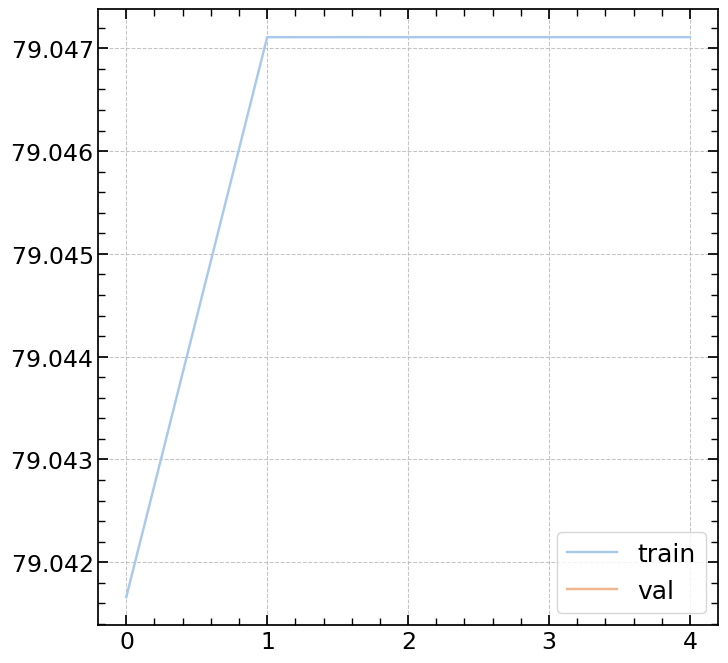

In [15]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

In [16]:
model.save()

Model SupConNetwork saved at epoch 5


# Measure performance

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

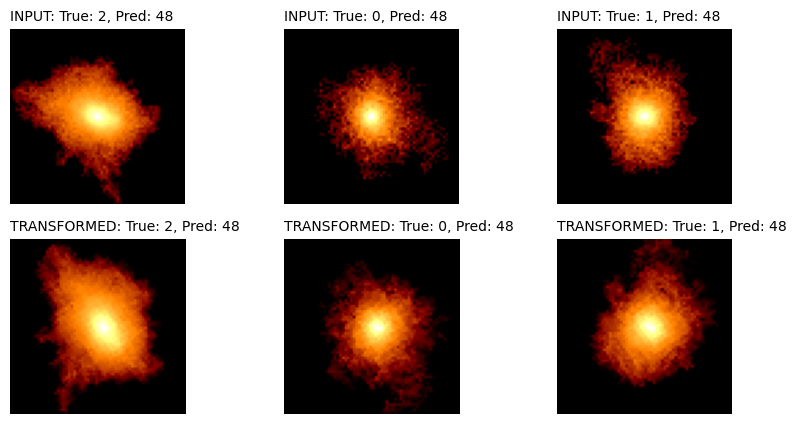

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]


In [19]:
model.show_transforms(train_loader, device);

# Embeddings

In [ ]:
from openTSNE import TSNE #!conda install --channel conda-forge opentsne -y
from tqdm import tqdm 

def gather_cnn_features(model, loader, device, transform = None):
    model.model.eval()
    cnn = model.model.cnn
    features = []
    labels = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            data, label = batch
            img = data[0]
            label = label[1]

            img = img.to(device)
            label = label.to(device)
            if transform is not None:
                img = transform(img)


            output = cnn(img).cpu().numpy()
            
            features.append(output)
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

features, labels = gather_cnn_features(model, train_loader, device, transform = img2d_transform)

In [ ]:
tsne = TSNE(
    n_components = 2,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

features_embedding = tsne.fit(features) 
#timing
#approx 3m30s min for first 1000 example of 78 batches of train dataloader (approx 1000 out of 9000 halos)
#approx 3m30s min for first all examples of 78 batches of train dataloader (approx 9000 halos)

In [ ]:
limit_labels = len(features_embedding)

fig, axs = plt.subplots(4, (len(np.unique(labels))+1)//4+1, figsize = (15,15))
axs=axs.flatten()


axs[0].scatter(features_embedding[:limit_labels, 0], features_embedding[:limit_labels, 1], c = 'k', s = 1)

for i,label in enumerate(np.unique(labels)):
    mask = labels[:limit_labels]==label
    axs[i+1].scatter(features_embedding[:limit_labels, 0][mask], features_embedding[:limit_labels, 1][mask], s = 30, alpha = 0.4)

    axs[i+1].set_title(label)

axs[0].set_title('all')

axs[i+1].set_xlabel('tsne1')
axs[0].set_ylabel('tsne2')



In [ ]:
plt.figure(figsize=(10,10))
for label in np.unique(labels):
    idx = labels[:1000] == label
    plt.scatter(features_embedding[idx, 0], features_embedding[idx, 1], label=str(label), s=30, alpha = 0.5)

plt.legend()

In [ ]:
idx

In [ ]:
features_embedding[:,0]